In [151]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

In [152]:
# Create *known* parameters
weight = -10.0
bias = 50.0

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[50.0000],
         [49.8000],
         [49.6000],
         [49.4000],
         [49.2000],
         [49.0000],
         [48.8000],
         [48.6000],
         [48.4000],
         [48.2000]]))

In [153]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

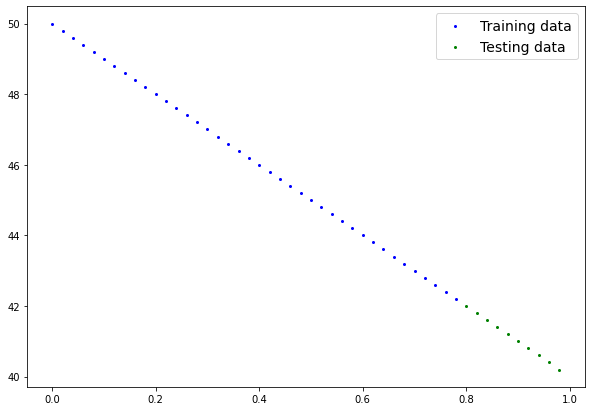

In [154]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});
plot_predictions();

In [155]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))
    
    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [156]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(45)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([-1.1224], requires_grad=True),
 Parameter containing:
 tensor([0.0312], requires_grad=True)]

In [157]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([-1.1224])), ('bias', tensor([0.0312]))])

In [158]:

# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

In [159]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[-0.8667],
        [-0.8892],
        [-0.9116],
        [-0.9341],
        [-0.9565],
        [-0.9790],
        [-1.0014],
        [-1.0239],
        [-1.0463],
        [-1.0687]])


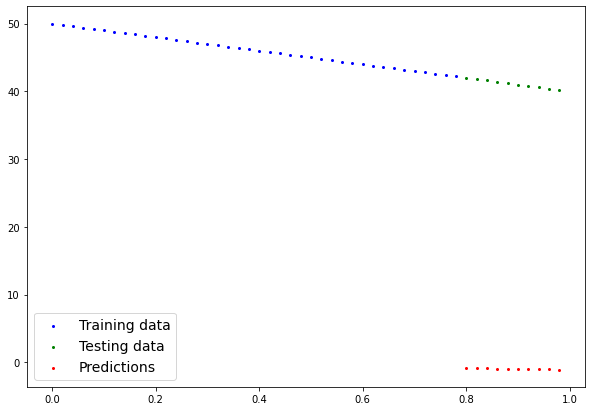

In [160]:
plot_predictions(predictions=y_preds)

In [161]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [162]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 20000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 46.506553649902344 | MAE Test Loss: 42.05426788330078 
Epoch: 10 | MAE Train Loss: 46.39133834838867 | MAE Test Loss: 41.9195556640625 
Epoch: 20 | MAE Train Loss: 46.27613067626953 | MAE Test Loss: 41.78484344482422 
Epoch: 30 | MAE Train Loss: 46.16092300415039 | MAE Test Loss: 41.6501350402832 
Epoch: 40 | MAE Train Loss: 46.04570770263672 | MAE Test Loss: 41.515419006347656 
Epoch: 50 | MAE Train Loss: 45.93050003051758 | MAE Test Loss: 41.380714416503906 
Epoch: 60 | MAE Train Loss: 45.81528854370117 | MAE Test Loss: 41.246002197265625 
Epoch: 70 | MAE Train Loss: 45.70008087158203 | MAE Test Loss: 41.11129379272461 
Epoch: 80 | MAE Train Loss: 45.584869384765625 | MAE Test Loss: 40.976585388183594 
Epoch: 90 | MAE Train Loss: 45.46965789794922 | MAE Test Loss: 40.84186935424805 
Epoch: 100 | MAE Train Loss: 45.35444641113281 | MAE Test Loss: 40.70716094970703 
Epoch: 110 | MAE Train Loss: 45.239234924316406 | MAE Test Loss: 40.57245635986328 
Epoch: 120

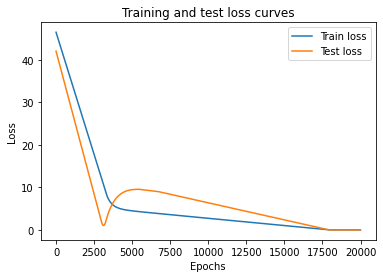

In [163]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [164]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([-9.9912])), ('bias', tensor([50.0041]))])

And the original values for weights and bias are:
weights: -10.0, bias: 50.0


In [165]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[42.0112],
        [41.8114],
        [41.6115],
        [41.4117],
        [41.2119],
        [41.0121],
        [40.8123],
        [40.6124],
        [40.4126],
        [40.2128]])

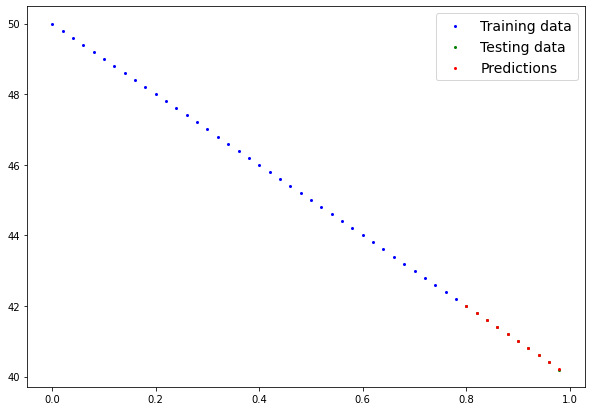

In [167]:
plot_predictions(predictions=y_preds)

In [171]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_0.pth


In [173]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [175]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [177]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [179]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [181]:
#######################################################
# USANDO LA FUNCION NN.LINEAR EN VEZ DE DEFINIRLA NOSOTROS

In [183]:

# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [186]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

In [189]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

In [192]:
torch.manual_seed(42)

# Set the number of epochs 
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 100 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 200 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 300 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 400 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 500 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 600 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 700 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 800 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188
Epoch: 900 | Train loss: 0.004988288972526789 | Test loss: 0.010038375854492188


In [195]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[-9.9969]], device='cuda:0')),
             ('linear_layer.bias', tensor([49.9938], device='cuda:0'))])

And the original values for weights and bias are:
weights: -10.0, bias: 50.0


In [197]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[41.9963],
        [41.7964],
        [41.5964],
        [41.3965],
        [41.1965],
        [40.9966],
        [40.7967],
        [40.5967],
        [40.3968],
        [40.1968]], device='cuda:0')

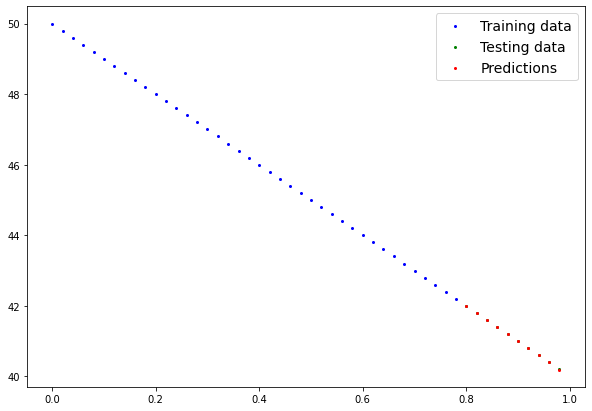

In [198]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())